In [31]:
# Load relevant R packages
inLibraries = list('repr','rgdal','rgeos','sp')
for (rpack in inLibraries) {
  if (is.element(rpack,installed.packages()[,1])){            
      #Load the library into R
      suppressMessages(library(rpack,character.only = TRUE))
    }
    else {
        print(paste("Warning:  ",rpack," is not an installed package"))
    }
}
#resize plot area
options(repr.plot.width=6, repr.plot.height=6)

# Missle silos

Let's look at Minuteman II silo locations and look at what impact they could have on surrounding schools and populations. One might wish to identify which census tracts and schools could be at risk given a disaster at any of the silo sites. To this end, one approach might be to identify which schools and populated areas are within some distance of the silos of concern.

In [32]:
silos <- readOGR("datasets/silos", "FEDERAL_FACILS")

OGR data source with driver: ESRI Shapefile 
Source: "datasets/silos", layer: "FEDERAL_FACILS"
with 264 features
It has 3 fields


In [33]:
schools <- readOGR("datasets/silos", "schoolPublic")

OGR data source with driver: ESRI Shapefile 
Source: "datasets/silos", layer: "schoolPublic"
with 2335 features
It has 23 fields


In [34]:
pop <- readOGR("datasets/silos", "st_tract10")

OGR data source with driver: ESRI Shapefile 
Source: "datasets/silos", layer: "st_tract10"
with 1393 features
It has 37 fields
Integer64 fields read as strings:  ALAND10 AWATER10 POP90 WHITE90 BLACK90 ASIAN90 AMIND90 OTHER90 HISP90 POP00 WHITE00 BLACK00 ASIAN00 AMIND00 HAWNPI00 OTHER00 MULTRA00 HISP00 POP10 WHITE10 BLACK10 ASIAN10 AMIND10 HAWNPI10 OTHER10 MULTRA10 HISP10 


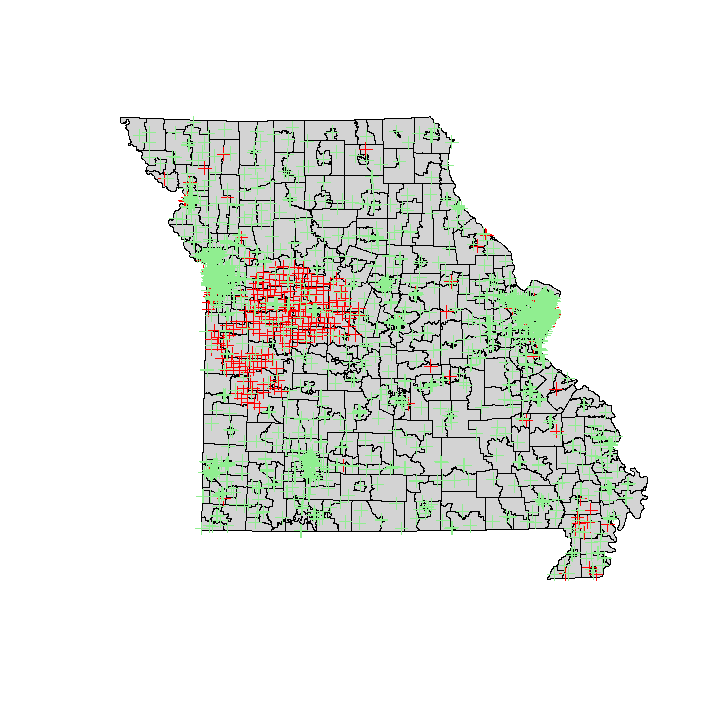

In [35]:
plot(pop, col = "lightgray")
plot(silos, col = "red", add = TRUE)
plot(schools, col = 'lightgreen', add = TRUE)

Consider an event at a silo would impact locations within 18.64 miles of the silo. To model this scenario, one might generate buffers for each silo. Buffer all silos by 18.64 miles (remember the coordinate system of the data is in meters) such that each silo has its own buffer polygon. Display the silos and their buffer areas.

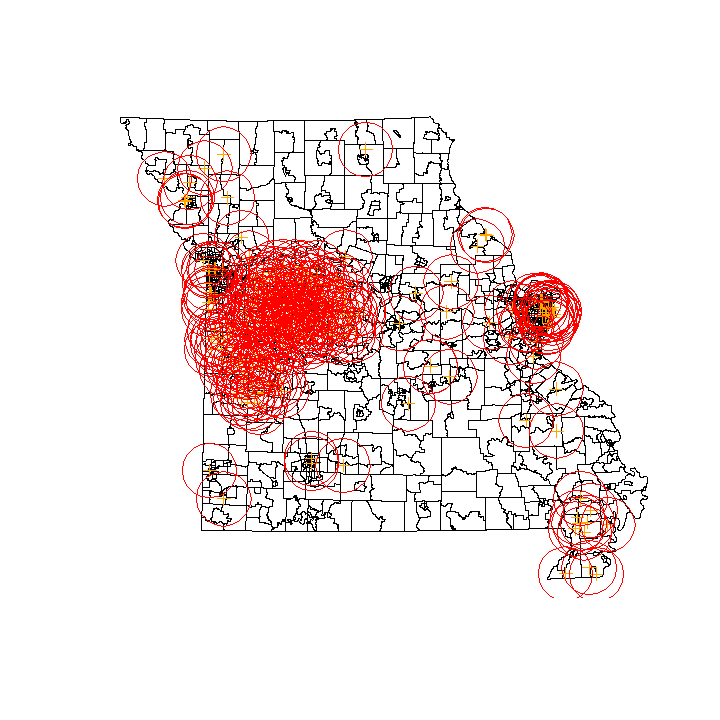

In [36]:
silosBuffer <- gBuffer(silos, 
                          byid = TRUE,
                          id = NULL, 
                          width = 30000,
                          quadsegs = 5, 
                          capStyle = "ROUND",
                          joinStyle = "ROUND", 
                          mitreLimit = 1.0)

plot(pop, col = "white", lwd = 0.1)
plot(silos, col = "orange", add = TRUE)
plot(silosBuffer, add = TRUE, border = "red", lwd = 0.5)

Since we'd like to determine the number of schools within range of a silo, redunancies/overlaps among the separate buffer areas should be removed. One way to accomplish this is to compute the geometric union of the buffer areas...give that a shot. Compute the geometric union of the buffer areas and display the silo points and the union of areas on the screen.

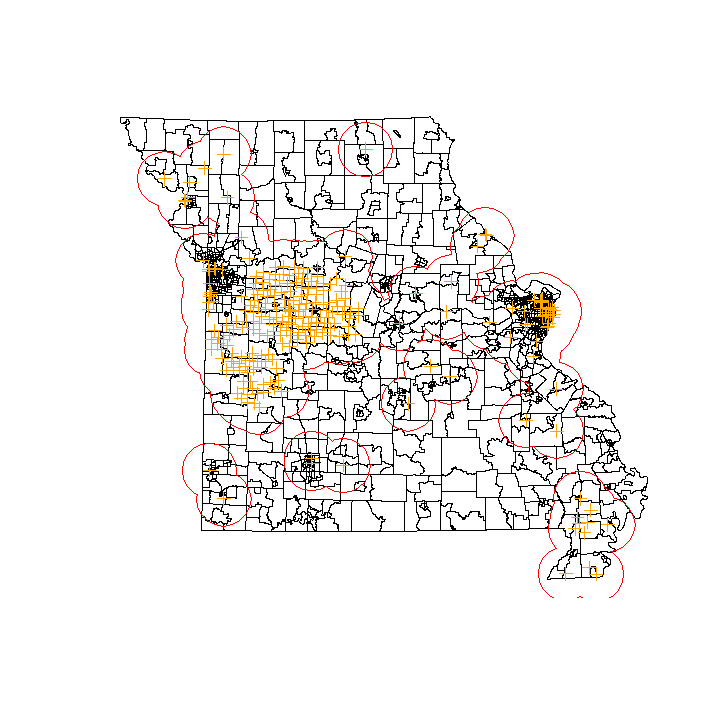

In [37]:
bufferUnion <- gUnaryUnion(silosBuffer)

plot(pop, col = "white", lwd = 0.1)
plot(silos, col = "orange", add = TRUE)
plot(bufferUnion, border = "red", add = TRUE)

Let's consider the geometric intersection of the single silo buffer area with public schools. The intersection of the schools with the buffer areas should return all schools that are within 18.64 miles of a silo. Use the over() function to compute this geometric intersection between the schools and the union of buffer areas, report the number of schools at risk, and display those schools and the silo buffer areas (the union layer) on the screen.

In [38]:
intersect <- overGeomGeom(bufferUnion, schools, returnList = TRUE, fn = NULL)

intersect <- unlist(intersect)

paste("There are ", length(intersect), "intersecting features")

[1] "There are  1711 intersecting features"

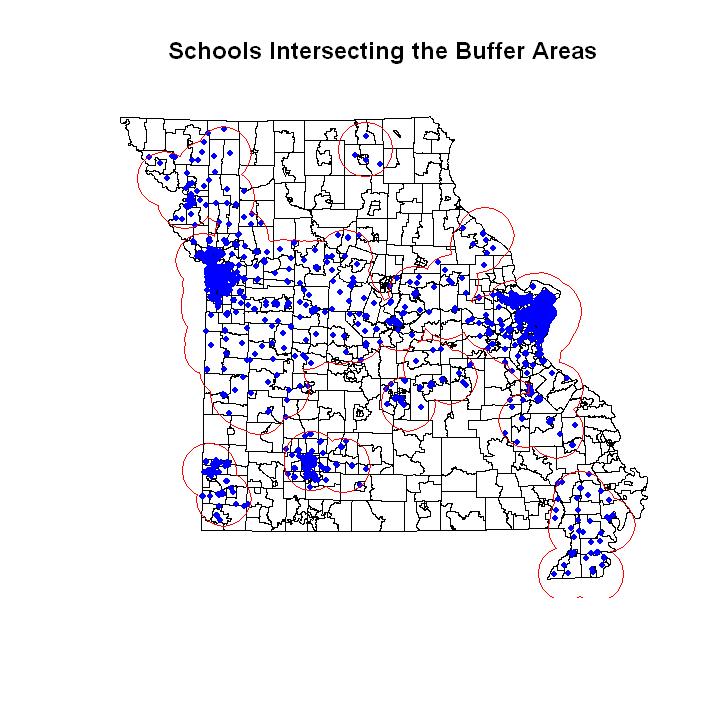

In [39]:
intFeat <- schools[intersect, ]

plot(pop, col = "white", main = "Schools Intersecting the Buffer Areas", lwd = 0.1)
plot(intFeat, col = "blue", add = TRUE, pch = 20)
plot(bufferUnion, border = "red", lwd = "0.7", add = TRUE)

In the schools dataset, there is a field 'Enrollment' that represents the number of students enrolled in each school. 

In [40]:
head(schools@data)

ID,CtyDist,SchNum,SchID,Facility,Address,Address2,City,State,ZIP,...,BGrade,EGrade,Principal,PrinTitle,Teachers,Enrollment,SchEmail,Latitude,Longitude,Loc_Code
1,001090,1050,001090-1050,Adair Co. High,600 Rombauer Ave,NA,Novinger,MO,635592477,...,07,12,Mr. Rick Johnson,Prin.,22,135,rjohnson@novinger.k12.mo.us,40.23467,-92.70365,MAP_MU
2,001090,4020,001090-4020,Adair Co. Elem.,600 Rombauer Ave,NA,Novinger,MO,635592477,...,K,06,Mrs. Connie J Charles,Prin.,18,131,ccharles@novinger.k12.mo.us,40.23472,-92.70366,MAP_MU
3,001091,1050,001091-1050,Kirksville Sr. High,1300 S Cottage Grove,NA,Kirksville,MO,635013910,...,09,12,Mr. Randy Mikel,Prin.,60,804,RANDY_M@kirksville.k12.mo.us,40.18549,-92.56610,MAP_MU
4,001091,1100,001091-1100,Kirksville Area Tech. Ctr.,1103 S Cottage Grove,NA,Kirksville,MO,635013977,...,09,12,Mrs. Teresa Jones,Dir.,19,0,Terri_J@kirksville.k12.mo.us,40.18627,-92.56508,MAP_MU
5,001091,3000,001091-3000,Kirksville Middle,1515 S Cottage Grove,NA,Kirksville,MO,635013979,...,06,08,Dr. Michael Mitchell,Prin.,48,546,MMITCHELL@kirksville.k12.mo.us,40.18339,-92.56562,MAP_MU
6,001091,4030,001091-4030,Kirksville Primary,1815 E Hamilton,NA,Kirksville,MO,635013903,...,PK,02,Mrs. Tricia Reger,Prin.,73,656,TREGER@kirksville.k12.mo.us,40.18357,-92.56302,MAP_MU


In [41]:
schoolsRisk <- schools[intersect, ]

studentsRisk <- sum(schoolsRisk@data$Enrollment)

paste("There are ", studentsRisk, "students at risk.")

[1] "There are  723268 students at risk."

Determine how many census tracts may be at risk. To do this, compute the intersection between the tract polygons and the union of buffer areas, report the number of intersecting features, and plot the tracts at risk and the union of buffer areas on the screen (make sure the union areas are visible over the tracts).

[1] "There are 1210 intersecting tracts"

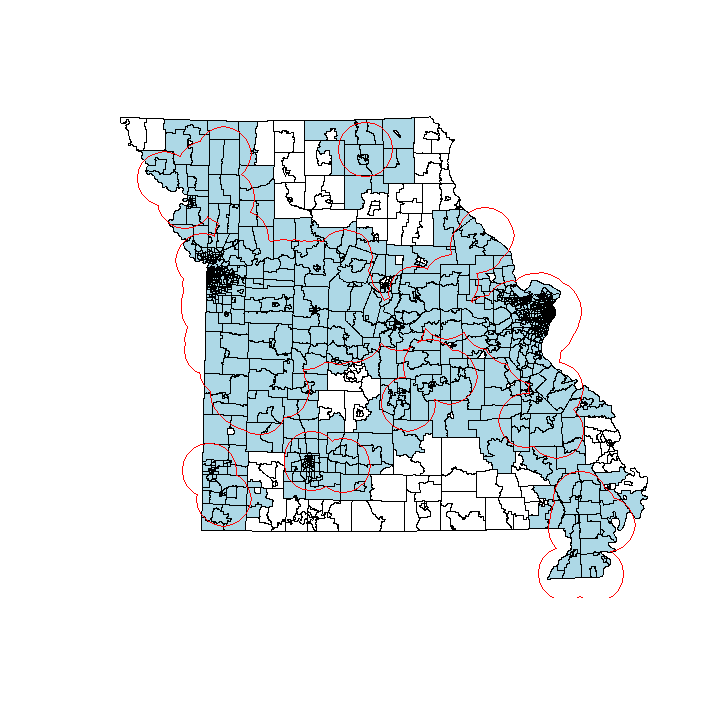

In [42]:
censusInt <- overGeomGeom(bufferUnion, pop, returnList = TRUE, fn = NULL)
intSet <- unlist(censusInt)

intCensus <- pop[intSet,]

paste("There are", length(intCensus), "intersecting tracts")

plot(pop, col = "white", lwd = 0.1)
plot(intCensus, col = "lightblue", add = TRUE)
plot(bufferUnion, border = "red", add = TRUE)

Compute and report the population 'pop10' in 2010 that would be at risk to a silo disaster given their tract intersects the risk area associated with the silos.

In [43]:
head(intCensus@data)

,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,...,HISP00,POP10,WHITE10,BLACK10,ASIAN10,AMIND10,HAWNPI10,OTHER10,MULTRA10,HISP10
0,29,510,103700,29510103700,1037,Census Tract 1037,G5020,S,911113,0,...,70,2531,2260,129,55,3,3,30,51,93
1,29,510,103800,29510103800,1038,Census Tract 1038,G5020,S,1640946,35370,...,52,3819,3536,115,54,7,0,27,80,119
2,29,510,104200,29510104200,1042,Census Tract 1042,G5020,S,1121761,0,...,77,3401,2964,202,124,7,0,33,71,121
3,29,510,104500,29510104500,1045,Census Tract 1045,G5020,S,1939712,0,...,33,1846,1423,249,94,4,0,18,58,55
4,29,510,105198,29510105198,1051.98,Census Tract 1051.98,G5020,S,1162261,0,...,66,3463,2453,541,355,5,1,19,89,107
5,29,510,105200,29510105200,1052,Census Tract 1052,G5020,S,831270,0,...,43,2675,995,1388,169,18,4,13,88,75


In [44]:
pop10 <- sum(as.numeric(intCensus@data$POP10))
paste("There are ", pop10, "people at risk of a silo disaster in 2010")

[1] "There are  765814 people at risk of a silo disaster in 2010"

While you just evaluated tracts that intersect the silo risk areas, determine which tracts are completely contained within the risk areas. Remember, now those completely contained should be a subset of those intersecting. As such, we can iterate through the intersecting features to assess containment. Report the number of tracts completely contained in the silo risk areas and display those tracts and the union of areas on the screen.

In [45]:
i <- 1
containedList <- list()

for (subsel in censusInt){
    for (ele in subsel){
        if (gContains(bufferUnion, pop[ele, ], byid = FALSE, prepared = TRUE,
                         returnDense = TRUE, STRsubset = FALSE, checkValidity = FALSE)){
            
            containedList[[i]] <- ele
            i <- i + 1
        }
    }
}

contSet <- unlist(containedList)
paste("There are ", length(contSet), "completely contained features")

[1] "There are  1031 completely contained features"

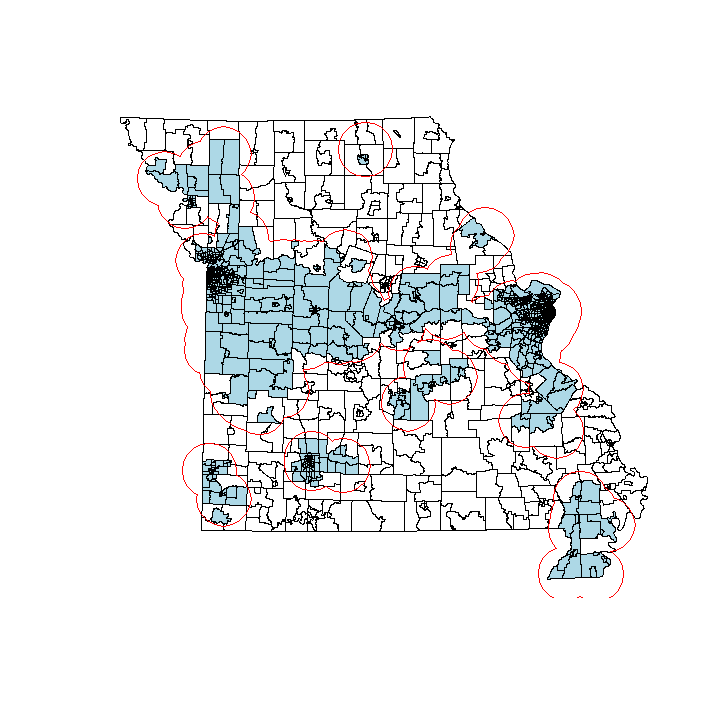

In [46]:
contFeat <- pop[contSet, ]

plot(pop, col = "white", lwd = 0.1)
plot(contFeat, col = "lightblue", add = TRUE)
plot(bufferUnion, border = "red", add = TRUE)

Compute and report the population 'pop10' in 2010 that would be at risk to a silo disaster given their tract is contained within the risk area associated with the silos.

In [47]:
containedPop10 <- sum(as.numeric(contFeat@data$POP10))

paste("There are", containedPop10, "contained people at risk.")

[1] "There are 645731 contained people at risk."

In [48]:
centroids <- gCentroid(pop, byid = TRUE)
head(centroids)

SpatialPoints:
         x       y
0 735808.3 4276761
1 734337.7 4275563
2 735030.1 4278998
3 736706.8 4278844
4 734986.3 4281329
5 735936.3 4281487
Coordinate Reference System (CRS) arguments: +proj=utm +zone=15
+datum=NAD83 +units=m +no_defs +ellps=GRS80 +towgs84=0,0,0 

Display the tracts and their respective centroids.

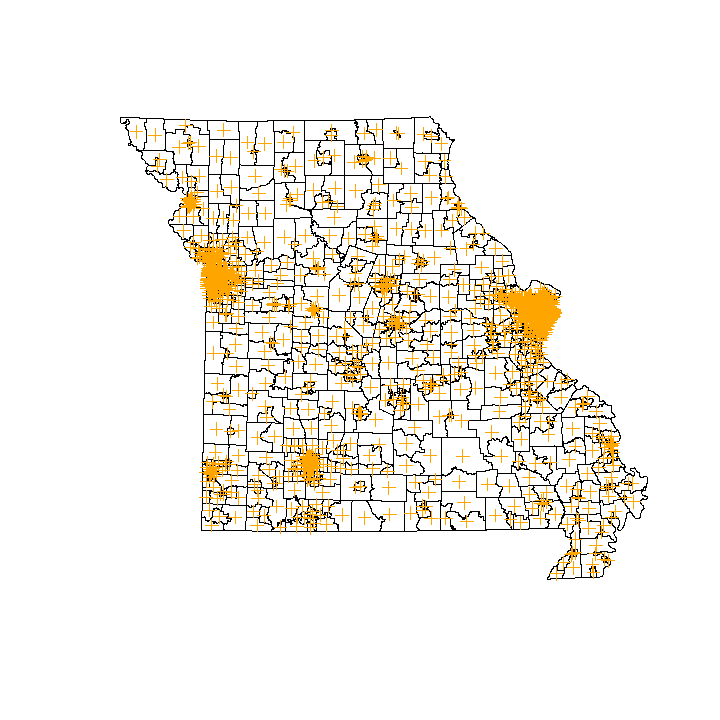

In [49]:
plot(pop, col = "white", lwd = 0.1)
plot(centroids, col = "orange", add = TRUE)

Identify which tract centroids intersect with the silo risk areas. Report the number of intersecting features and display the centroid and polygons of the intersecting tracts as well as the union of risk areas.

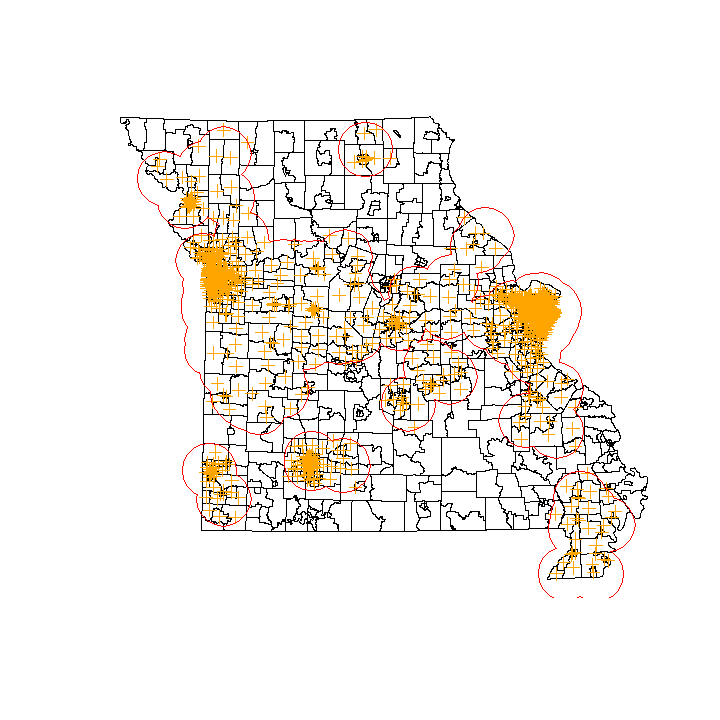

In [50]:
riskyCentroids <- overGeomGeom(bufferUnion, centroids, returnList = TRUE, fn = NULL)
riskyCentroids <- unlist(riskyCentroids)
riskyCentroids <- centroids[riskyCentroids, ]

plot(pop, col = "white", lwd = 0.1)
plot(riskyCentroids, col = "orange", add = TRUE, lwd = 0.5)
plot(bufferUnion, border = "red", lwd = 0.5, add = TRUE)